# Gradient Symbolic Computation

see `TPR_example.ipynb` for details about the TP representation and one possible empirical phenomenon, that can be handled with GSC.

In [1]:
# Imports
from src.classes.Grammar import Grammar
from src.gsc.gsc_network import Net
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
# Set seed for reproducibility
torch.manual_seed(123)

## Grammar and Harmonic Constraints

In [2]:
# Fillers and Roles
fillers = ["bh", "b", "u", "d", "dh"]
# The simplest possible roles: s1 = first position in the word, s2 = second position ....
roles = ["s1", "s2", "s3","s4"]

"""similarities = torch.tensor([[1, 0.5, 0, 0, 0,0],
                             [0.5, 1, 0, 0, 0,0],
                             [0, 0, 1, 0, 0,0],
                             [0, 0, 0, 1, 0.5,0],
                             [0, 0, 0, 0.5, 1,0],
                              [0, 0, 0, 0, 0,1]])"""

# Build Grammar
G = Grammar(fillers, roles, emtpyFiller="#")
#G = Grammar(fillers, roles, emtpyFiller="#", fillerSimilarities=similarities)

Buil Filler Matrix
Representations built after 224 attempts

Build role Matrix
Representations built after 219 attempts



In [3]:
print(f"Roles representation matrix:\n{pd.DataFrame(G.bind.R.numpy(), index=roles, columns=roles)}\n")
print(f"Fillers representation matrix:\n{pd.DataFrame(G.bind.F.numpy(), index=fillers, columns=fillers)}\n")

Roles representation matrix:
          s1        s2        s3        s4
s1 -0.706786 -0.245139 -0.450434  0.487308
s2  0.334344 -0.780347 -0.430909 -0.305926
s3  0.537700 -0.161073  0.128452  0.817578
s4 -0.315509 -0.552287  0.771314 -0.022488

Fillers representation matrix:
          bh         b         u         d        dh         #
bh  0.268915 -0.226856  0.369631 -0.588528  0.522140  0.347274
b  -0.040153 -0.228537  0.764934  0.441927  0.133732 -0.384513
u  -0.684379  0.453295  0.208536 -0.449616  0.076696 -0.273175
d  -0.021590 -0.388657  0.257805 -0.388855 -0.793899  0.023089
dh  0.676026  0.534180  0.126280 -0.201687 -0.152363 -0.421664
#   0.014784 -0.504409 -0.390321 -0.253565  0.223861 -0.691804



## Single Constituents Harmony

The following code sets the harmony values for single bindings. 
For instance the constraint `("b/s1", 2)` means that the segment "b" in first position ("s1") improves the general harmony by 2. 

There will be *Harmony crosstalk* if the vector representing those bindings are not independent (dot product == 0). Let's suppose that the vector representing "b/s1" has a non-null dotproduct with the vector representing "bh/s1". Then "bh/s1" will also improve its harmony by a factor $H_{b/s1} \times (b/s1 \cdot bh/s1)$


In [4]:
# Single Harmony constraints
cons = [("b/s1", 2), ("u/s2", 5), ("dh/s3", 2), ("#/s4", 2)] # initialize preferences (dummy-way to reinforce the desired output)
G.update_Hc(cons)

In [5]:
harmonies = G.Hc.numpy()
harmonies = pd.DataFrame(harmonies, columns=roles, index=fillers)
harmonies

,s1,s2,s3,s4
bh,0.0,0.0,0.0,0.0
b,2.0,0.0,0.0,0.0
u,0.0,5.0,0.0,0.0
d,0.0,0.0,0.0,0.0
dh,0.0,0.0,2.0,0.0
#,0.0,0.0,0.0,2.0


<AxesSubplot:>

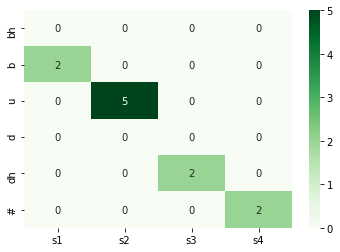

In [6]:
sns.heatmap(harmonies, annot=True, cmap="Greens")

## Pairwise Harmonies:

These constraints provide a way to declare Harmonic Constraints in the GSC. 
Ex.:

`("u/s2" "d/s3", -3)` means that the co-occurence of "u" in the secondo position and "d" in the third position updates the total Harmony by -3 points. This  (indirectly) implement the preference for "dh" in "s3".


In [7]:
# Pairwise Harmony
# Matrix dim: (nF, nR, nF, nR)
cons = [("b/s1", "d/s3", -4), # having both "b" abd "d" unaspirated decreases harmony
        ("bh/s1", "dh/s3", -10), # having both "b" and "d" aspirated is blocked
        ("b/s1", "dh/s3", 10)] # Prefer alternation
G.update_Hcc(cons)

In [8]:
# Harmonies for the binding : b/s1
harmonies = G.Hcc.numpy()[:,:,1,0]
harmonies = pd.DataFrame(harmonies, columns=roles, index=fillers)
harmonies

,s1,s2,s3,s4
bh,0.0,0.0,0.0,0.0
b,0.0,0.0,0.0,0.0
u,0.0,0.0,0.0,0.0
d,0.0,0.0,-4.0,0.0
dh,0.0,0.0,10.0,0.0
#,0.0,0.0,0.0,0.0


<AxesSubplot:>

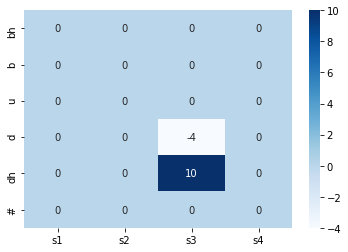

In [9]:
sns.heatmap(harmonies, annot=True, cmap="Blues")

This matrix represents the occurence of "b" in the first position and tells us, that if this is the case, then a plain, unaspirated, "d" in the third position is dispreferred and "dh" should be preferred. 

## GSC Net

In [10]:
# Custom settings (these substitute the hard-coded settings)

# ---------------------------------------
#           GSC NET
# ---------------------------------------

custom_settings = {"epochs": 5,
                   "tgtStd": 0.00125,
                   "emaFactor": 0.1,
                   "emaSpeedTol": 0.002,
                   "dt": 1e-5,
                   "TDecayRate": 0.05,
                   "TInit" : 1e-5,
                   "lambdaDecayRate": 0.7,
                   "lambdaMin": 0.01,
                   "maxSteps": 10000,
                   "printInterval": 5000,
                   'bowl_center': 0.4,
                   'beta_min_offset': .01}
# Initialize
N = Net(G, custom_settings=custom_settings, extData_path="data/inp_pandas.csv")


Input processed: b-bh-u-dh-u

Input processed: b-u-dh-#

Input processed: b-bh-u-dh-d

Value for Q set to 34.0654649196418
LAMBDA RECOMMENDED: 0.005128337201762921, ACTUAL LAMBDA = 0.011387


If you want to change to the recommended Lambda value press 'y', else any other key: y


T RECOMMENDED: 3.067529055692414e-05, ACTUAL T = 1e-05


If you want to change to the recommended value press 'y', else any other key: y


The external data were provided in form of a simple csv file and were imported in the GSCNet using `pandas`:

In [11]:
# EXTERNAL INPUTS 

# Read dataframe
inputs = pd.read_csv("data/inp_pandas.csv", sep=",")

inputNames = []
nStimuli = len(inputs['id'].unique())

# Initialize stimuli tensor
stimuli = torch.zeros((nStimuli, len(fillers) + 1, len(roles)))

# Loop over the single inputs as whole
for idx, i in enumerate(inputs['id'].unique()):
    inp_string = ""
    stimulus = inputs[inputs.id == i].to_numpy()[:, 1:]

    # Loop over the fillers in a given input
    for filler in stimulus:
        fidx = N.filler2index[filler[0]]
        inp_string += filler[0] + "-"
        for roledix in range(N.grammar.bind.nR):
            stimuli[idx, fidx, roledix] = filler[roledix+1]
    print(f"Input processed: {inp_string[:-1]}\n")
    # Store the names for later plotting
    inputNames.append(inp_string[:-1])

Input processed: b-bh-u-dh-u

Input processed: b-u-dh-#

Input processed: b-bh-u-dh-d



+ First inp: gradient blend for the root *{b, bh}udhu*:
+ Second inp: discrete *budh*
+ Third inp: gradient blend in both first and final position *{b,bh}u{d,dh}*

<small>'#' stands for an empty position</small>

     s1   s2   s3   s4
bh  0.7  0.0  0.0  0.0
b   0.8  0.0  0.0  0.0
u   0.0  1.0  0.0  1.0
d   0.0  0.0  0.0  0.0
dh  0.0  0.0  1.0  0.0
#   0.0  0.0  0.0  0.0


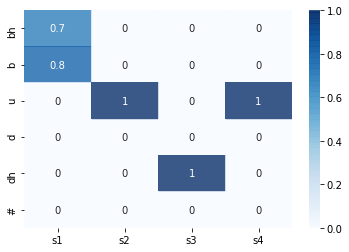

Representation of '(b,bh)udh'


In [12]:
b_bh_ud = N.stimuli[0,:,:].numpy()
b_bh_ud = pd.DataFrame(b_bh_ud, columns=roles, index=fillers)
print(b_bh_ud)
sns.heatmap(b_bh_ud, alpha=.8, cmap="Blues", annot=True)
plt.show()
print("Representation of '(b,bh)udh'")

## Training (Optimization + Quantization)

In [13]:
# Run
p = N()

Stimulus routine::   0%|          | 0/3 [00:00<?, ?it/s]

Value for Q set to 34.0654649196418

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.005128337201762921	 Harmony: 52.7529182434082

epoch : 1
stimNum : 1

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.245024  0.400000  0.400000  0.400000
b   0.619290  0.400000  0.400000  0.400000
u   0.400000  0.576131  0.400000  0.429355
d   0.400000  0.400000  0.327282  0.400000
dh  0.400000  0.400000  0.597932  0.400000
#   0.400000  0.400000  0.400000  0.458710
Nearest TP: b-u-dh-# --- Input : b-bh-u-dh-u
Distance between prediction and nearest TP: 1.9623334314238972

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.005412896792603486	 Harmony: 29.899707794189453

epoch : 1
stimNum : 1

Conceptual Matrix:
              s1        s2        s3        s4
bh  4.119308e-17  0.440635  0.401064  0.374372
b   8.000000e-01  0.327290  0.402690  0.437733
u   4.184145e-01  1.000


Stimulus routine::  33%|███▎      | 1/3 [00:17<00:34, 17.11s/it]


Last best Harmony: 7.054507950365775

Value for Q set to 34.0654649196418

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.005680886922157587	 Harmony: 52.851966857910156

epoch : 1
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.221712  0.400000  0.400000  0.400000
b   0.628045  0.400000  0.400000  0.400000
u   0.400000  0.576131  0.400000  0.400000
d   0.400000  0.400000  0.326254  0.400000
dh  0.400000  0.400000  0.607346  0.400000
#   0.400000  0.400000  0.400000  0.488066
Nearest TP: b-u-dh-# --- Input : b-u-dh-#
Distance between prediction and nearest TP: 1.941614265931285

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.005933171429753155	 Harmony: 29.29556655883789

epoch : 1
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.223842  0.439720  0.401071  0.375746
b   1.000000  0.326414  0.403743  0.437639


Stimulus routine::  67%|██████▋   | 2/3 [00:33<00:16, 16.46s/it]


Last best Harmony: 6.870054657146518

Value for Q set to 34.0654649196418

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.0061707658038359795	 Harmony: 52.50096130371094

epoch : 1
stimNum : 3

Conceptual Matrix:
          s1        s2        s3       s4
bh  0.247641  0.400000  0.400000  0.40000
b   0.621541  0.400000  0.400000  0.40000
u   0.400000  0.576131  0.400000  0.40000
d   0.400000  0.400000  0.335825  0.40000
dh  0.400000  0.400000  0.589019  0.40000
#   0.400000  0.400000  0.400000  0.45871
Nearest TP: b-u-dh-# --- Input : b-bh-u-dh-d
Distance between prediction and nearest TP: 1.9593106689343869

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.006394435906062117	 Harmony: 37.2245979309082

epoch : 1
stimNum : 3

Conceptual Matrix:
              s1        s2            s3        s4
bh  3.198467e-17  0.440527  4.001032e-01  0.376371
b   1.000000e+00  0.326591  4.


Stimulus routine::   0%|          | 0/3 [00:00<?, ?it/s]


Last best Harmony: 12.01332307924217

Value for Q set to 34.0654649196418

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.006605082046984307	 Harmony: 52.87411117553711

epoch : 2
stimNum : 1

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.245024  0.400000  0.400000  0.400000
b   0.619290  0.400000  0.400000  0.400000
u   0.400000  0.576131  0.400000  0.429355
d   0.400000  0.400000  0.327282  0.400000
dh  0.400000  0.400000  0.597932  0.400000
#   0.400000  0.400000  0.400000  0.458710
Nearest TP: b-u-dh-# --- Input : b-bh-u-dh-u
Distance between prediction and nearest TP: 1.9623334314238972

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.006803383223329476	 Harmony: 29.91191291809082

epoch : 2
stimNum : 1

Conceptual Matrix:
              s1        s2        s3        s4
bh  1.034961e-16  0.439849  0.401085  0.375180
b   8.000000e-01  0.327096  0.4


Stimulus routine::  33%|███▎      | 1/3 [00:16<00:33, 16.71s/it]


Last best Harmony: 7.028968152720971

Value for Q set to 34.0654649196418

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.006990137631369261	 Harmony: 52.935333251953125

epoch : 2
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.221712  0.400000  0.400000  0.400000
b   0.628045  0.400000  0.400000  0.400000
u   0.400000  0.576131  0.400000  0.400000
d   0.400000  0.400000  0.326254  0.400000
dh  0.400000  0.400000  0.607346  0.400000
#   0.400000  0.400000  0.400000  0.488066
Nearest TP: b-u-dh-# --- Input : b-u-dh-#
Distance between prediction and nearest TP: 1.941614265931285

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.007165947255223771	 Harmony: 29.29166603088379

epoch : 2
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.223191  0.440096  0.400581  0.375156
b   1.000000  0.325976  0.402698  0.437188


Stimulus routine::  67%|██████▋   | 2/3 [00:32<00:16, 16.27s/it]


Last best Harmony: 6.766017987385666

Value for Q set to 34.0654649196418

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.007331519758805357	 Harmony: 52.52628707885742

epoch : 2
stimNum : 3

Conceptual Matrix:
          s1        s2        s3       s4
bh  0.247641  0.400000  0.400000  0.40000
b   0.621541  0.400000  0.400000  0.40000
u   0.400000  0.576131  0.400000  0.40000
d   0.400000  0.400000  0.335825  0.40000
dh  0.400000  0.400000  0.589019  0.40000
#   0.400000  0.400000  0.400000  0.45871
Nearest TP: b-u-dh-# --- Input : b-bh-u-dh-d
Distance between prediction and nearest TP: 1.9593106689343869

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.00748738884848769	 Harmony: 37.24742889404297

epoch : 2
stimNum : 3

Conceptual Matrix:
              s1        s2            s3        s4
bh -1.056821e-17  0.440813  4.005321e-01  0.375994
b   1.000000e+00  0.326996  4.0


Stimulus routine::   0%|          | 0/3 [00:00<?, ?it/s]


Last best Harmony: 11.994716968248753

Value for Q set to 34.0654649196418

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.007634181924110487	 Harmony: 52.604270935058594

epoch : 3
stimNum : 1

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.245024  0.400000  0.400000  0.400000
b   0.619290  0.400000  0.400000  0.400000
u   0.400000  0.576131  0.400000  0.429355
d   0.400000  0.400000  0.327282  0.400000
dh  0.400000  0.400000  0.597932  0.400000
#   0.400000  0.400000  0.400000  0.458710
Nearest TP: b-u-dh-# --- Input : b-bh-u-dh-u
Distance between prediction and nearest TP: 1.9623334314238972

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.0077723721584431705	 Harmony: 29.93352508544922

epoch : 3
stimNum : 1

Conceptual Matrix:
              s1        s2        s3        s4
bh  3.545282e-17  0.439432  0.400671  0.374832
b   8.000000e-01  0.326870  


Stimulus routine::  33%|███▎      | 1/3 [00:16<00:33, 16.77s/it]


Last best Harmony: 7.037767252177645

Value for Q set to 34.0654649196418

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.007902515790898328	 Harmony: 52.99094772338867

epoch : 3
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.221712  0.400000  0.400000  0.400000
b   0.628045  0.400000  0.400000  0.400000
u   0.400000  0.576131  0.400000  0.400000
d   0.400000  0.400000  0.326254  0.400000
dh  0.400000  0.400000  0.607346  0.400000
#   0.400000  0.400000  0.400000  0.488066
Nearest TP: b-u-dh-# --- Input : b-u-dh-#
Distance between prediction and nearest TP: 1.941614265931285

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.008025032326433658	 Harmony: 29.327037811279297

epoch : 3
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.222909  0.439973  0.401433  0.374800
b   1.000000  0.325392  0.403193  0.437031


Stimulus routine::  67%|██████▋   | 2/3 [00:32<00:16, 16.27s/it]


Last best Harmony: 6.867804375161548

Value for Q set to 34.0654649196418

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.008140414915133808	 Harmony: 52.80448532104492

epoch : 3
stimNum : 3

Conceptual Matrix:
          s1        s2        s3       s4
bh  0.247641  0.400000  0.400000  0.40000
b   0.621541  0.400000  0.400000  0.40000
u   0.400000  0.576131  0.400000  0.40000
d   0.400000  0.400000  0.335825  0.40000
dh  0.400000  0.400000  0.589019  0.40000
#   0.400000  0.400000  0.400000  0.45871
Nearest TP: b-u-dh-# --- Input : b-bh-u-dh-d
Distance between prediction and nearest TP: 1.9593106689343869

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.008249035481211166	 Harmony: 37.29695510864258

epoch : 3
stimNum : 3

Conceptual Matrix:
              s1        s2            s3        s4
bh  6.191871e-17  0.440365  4.002302e-01  0.376134
b   1.000000e+00  0.326992  4.


Stimulus routine::   0%|          | 0/3 [00:00<?, ?it/s]


Last best Harmony: 12.159615607954564

Value for Q set to 34.0654649196418

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.00835133124108821	 Harmony: 52.837039947509766

epoch : 4
stimNum : 1

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.245024  0.400000  0.400000  0.400000
b   0.619290  0.400000  0.400000  0.400000
u   0.400000  0.576131  0.400000  0.429355
d   0.400000  0.400000  0.327282  0.400000
dh  0.400000  0.400000  0.597932  0.400000
#   0.400000  0.400000  0.400000  0.458710
Nearest TP: b-u-dh-# --- Input : b-bh-u-dh-u
Distance between prediction and nearest TP: 1.9623334314238972

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.008447631934895915	 Harmony: 29.994712829589844

epoch : 4
stimNum : 1

Conceptual Matrix:
              s1        s2        s3        s4
bh  9.713235e-17  0.439931  0.401069  0.374645
b   8.000000e-01  0.326519  0


Stimulus routine::  33%|███▎      | 1/3 [00:16<00:33, 16.75s/it]


Last best Harmony: 7.225906319220066

Value for Q set to 34.0654649196418

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.008538325189456263	 Harmony: 52.62084197998047

epoch : 4
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.221712  0.400000  0.400000  0.400000
b   0.628045  0.400000  0.400000  0.400000
u   0.400000  0.576131  0.400000  0.400000
d   0.400000  0.400000  0.326254  0.400000
dh  0.400000  0.400000  0.607346  0.400000
#   0.400000  0.400000  0.400000  0.488066
Nearest TP: b-u-dh-# --- Input : b-u-dh-#
Distance between prediction and nearest TP: 1.941614265931285

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.008623703345387066	 Harmony: 29.38780403137207

epoch : 4
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.223346  0.439841  0.400923  0.374887
b   1.000000  0.326780  0.403390  0.436307



Stimulus routine::  67%|██████▋   | 2/3 [00:32<00:16, 16.32s/it]


Last best Harmony: 7.022763948020668

Value for Q set to 34.0654649196418

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.008704110064420534	 Harmony: 52.36186981201172

epoch : 4
stimNum : 3

Conceptual Matrix:
          s1        s2        s3       s4
bh  0.247641  0.400000  0.400000  0.40000
b   0.621541  0.400000  0.400000  0.40000
u   0.400000  0.576131  0.400000  0.40000
d   0.400000  0.400000  0.335825  0.40000
dh  0.400000  0.400000  0.589019  0.40000
#   0.400000  0.400000  0.400000  0.45871
Nearest TP: b-u-dh-# --- Input : b-bh-u-dh-d
Distance between prediction and nearest TP: 1.9593106689343869

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.008779804529558063	 Harmony: 37.35502243041992

epoch : 4
stimNum : 3

Conceptual Matrix:
              s1        s2            s3        s4
bh -1.452378e-17  0.440257  4.001463e-01  0.375628
b   1.000000e+00  0.326737  4.


Stimulus routine::   0%|          | 0/3 [00:00<?, ?it/s]


Last best Harmony: 12.29331681132497

Value for Q set to 34.0654649196418

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.008851091424014254	 Harmony: 52.83045959472656

epoch : 5
stimNum : 1

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.245024  0.400000  0.400000  0.400000
b   0.619290  0.400000  0.400000  0.400000
u   0.400000  0.576131  0.400000  0.429355
d   0.400000  0.400000  0.327282  0.400000
dh  0.400000  0.400000  0.597932  0.400000
#   0.400000  0.400000  0.400000  0.458710
Nearest TP: b-u-dh-# --- Input : b-bh-u-dh-u
Distance between prediction and nearest TP: 1.9623334314238972

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.008918200533949804	 Harmony: 30.027040481567383

epoch : 5
stimNum : 1

Conceptual Matrix:
              s1        s2        s3        s4
bh  8.828191e-17  0.439901  0.400308  0.375037
b   8.000000e-01  0.326883  0.


Stimulus routine::  33%|███▎      | 1/3 [00:16<00:33, 16.84s/it]


Last best Harmony: 7.322329309195382

Value for Q set to 34.0654649196418

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.008981401985050935	 Harmony: 52.73989486694336

epoch : 5
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.221712  0.400000  0.400000  0.400000
b   0.628045  0.400000  0.400000  0.400000
u   0.400000  0.576131  0.400000  0.400000
d   0.400000  0.400000  0.326254  0.400000
dh  0.400000  0.400000  0.607346  0.400000
#   0.400000  0.400000  0.400000  0.488066
Nearest TP: b-u-dh-# --- Input : b-u-dh-#
Distance between prediction and nearest TP: 1.941614265931285

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.00904089950086216	 Harmony: 29.418930053710938

epoch : 5
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.223551  0.439597  0.400642  0.374524
b   1.000000  0.326970  0.403224  0.436240



Stimulus routine::  67%|██████▋   | 2/3 [00:32<00:16, 16.31s/it]


Last best Harmony: 7.160379426028534

Value for Q set to 34.0654649196418

--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.009096932569096746	 Harmony: 52.521522521972656

epoch : 5
stimNum : 3

Conceptual Matrix:
          s1        s2        s3       s4
bh  0.247641  0.400000  0.400000  0.40000
b   0.621541  0.400000  0.400000  0.40000
u   0.400000  0.576131  0.400000  0.40000
d   0.400000  0.400000  0.335825  0.40000
dh  0.400000  0.400000  0.589019  0.40000
#   0.400000  0.400000  0.400000  0.45871
Nearest TP: b-u-dh-# --- Input : b-bh-u-dh-d
Distance between prediction and nearest TP: 1.9593106689343869

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.009149681806735335	 Harmony: 37.405555725097656

epoch : 5
stimNum : 3

Conceptual Matrix:
              s1        s2            s3        s4
bh  6.003610e-18  0.440092  4.005884e-01  0.376392
b   1.000000e+00  0.327277  


Epoch routine:: 100%|██████████| 5/5 [04:07<00:00, 49.60s/it]


Last best Harmony: 12.463496959585115



# Visualization

In [14]:
from src.gsc.plotting import Plot

In [15]:
fp = "data/full_traces.pt"
nr = len(roles)
nf = len(fillers) +1 
statesDict = G.bind.states
inputNames = N.inputNames


p = Plot(fp_traces="data/full_traces.pt", nf=nf,nr=nr, inputNames=inputNames, statesDict=statesDict)

Given input: '(0.7 x bh + 0.8 x b)-u-dh-u'


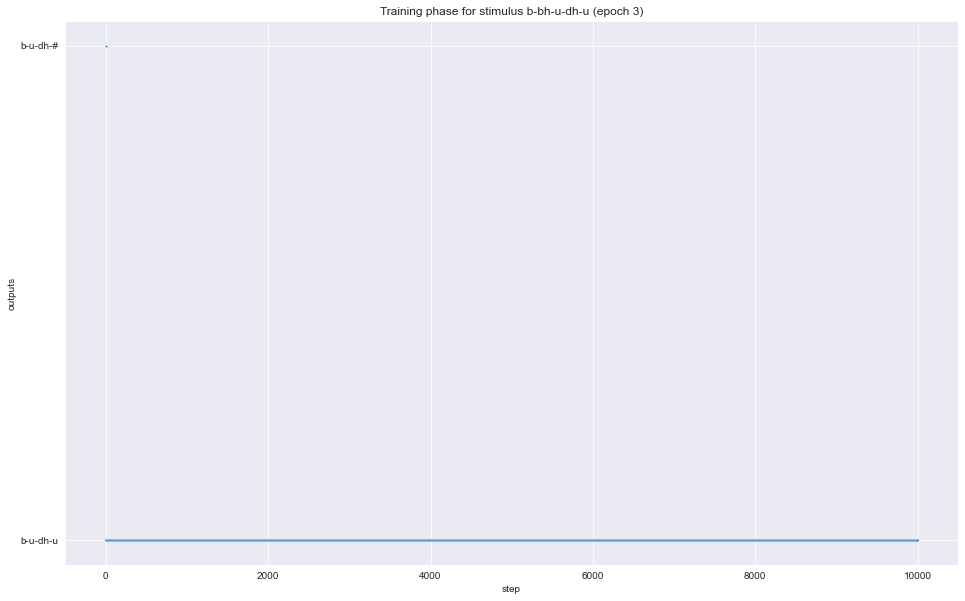

In [33]:
print("Given input: '(0.7 x bh + 0.8 x b)-u-dh-u'")
plt.figure(figsize=(16,10))
df = p.plot_epoch(0, 3)

Given input: 'b-u-dh'


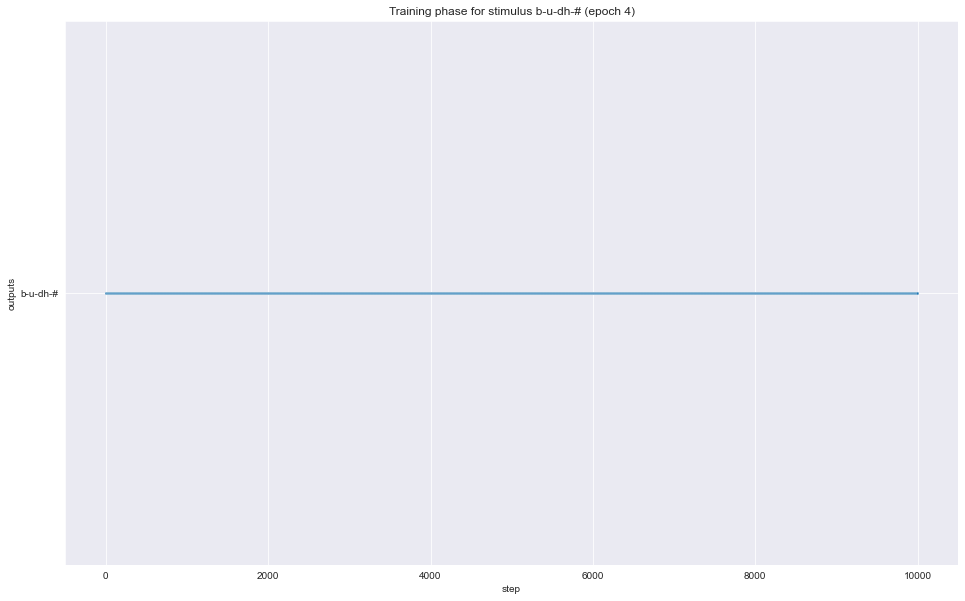

In [34]:
print("Given input: 'b-u-dh'")
plt.figure(figsize=(16,10))
df = p.plot_epoch(1, 4)

Given input: '(0.7 x bh + 0.8 x bh)-u-(.7 x d + .8 x dh)'


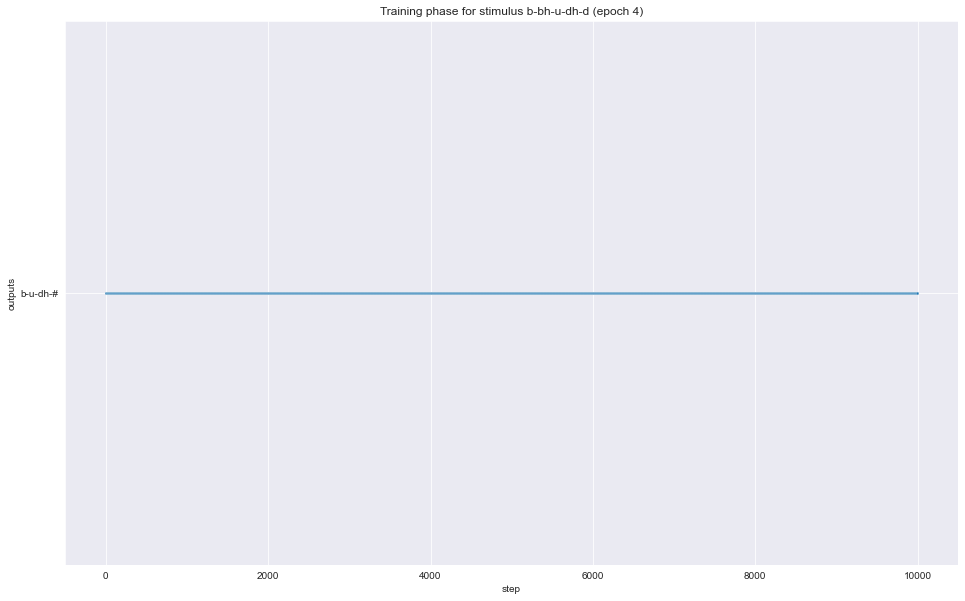

In [35]:
print("Given input: '(0.7 x bh + 0.8 x bh)-u-(.7 x d + .8 x dh)'")
plt.figure(figsize=(16,10))
df = p.plot_epoch(2, 4)

### Harmonies and Frequencies

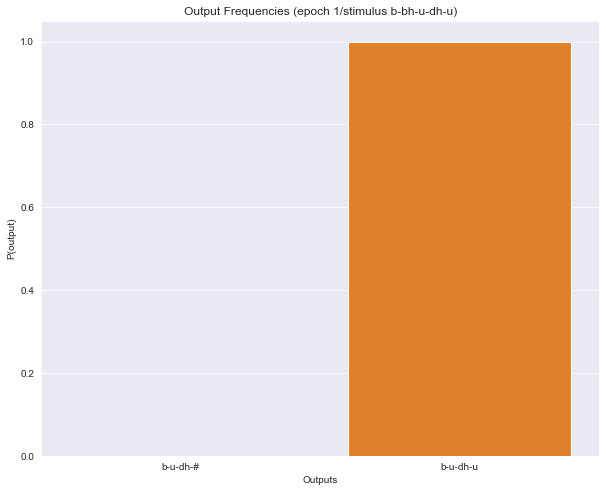

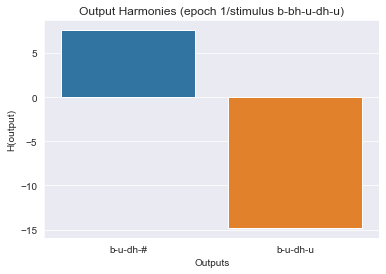

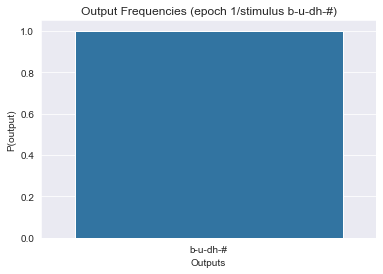

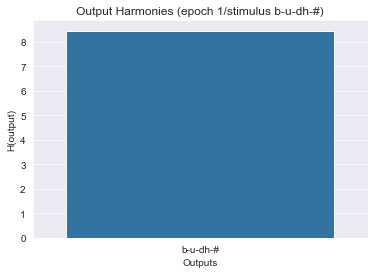

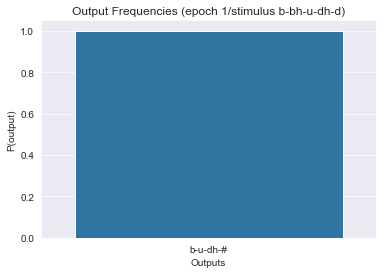

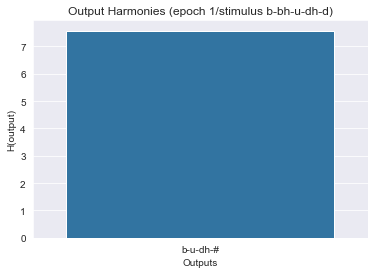

In [19]:
plt.figure(figsize=(10,8))
df = p.plot_final_states(save=True)

### Harmony vs. Activation

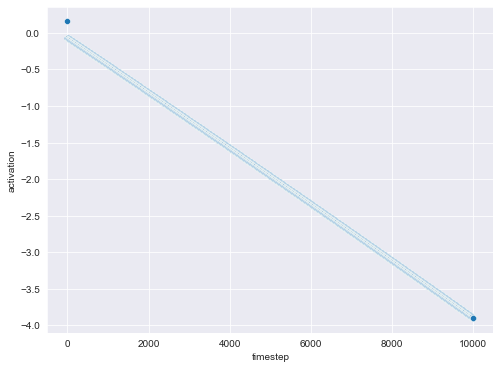

In [20]:
plt.figure(figsize=(8,6))
df = p.plot_act_stim(0,4, save=True)

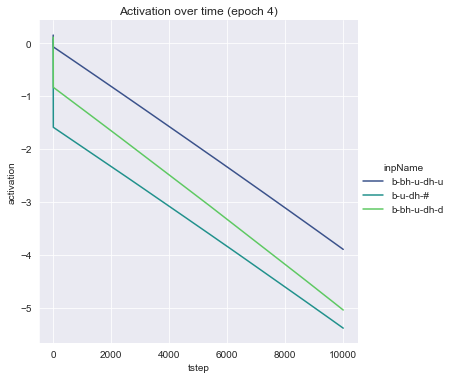

In [21]:
df = p.plot_input_tstep(4,what="activation")

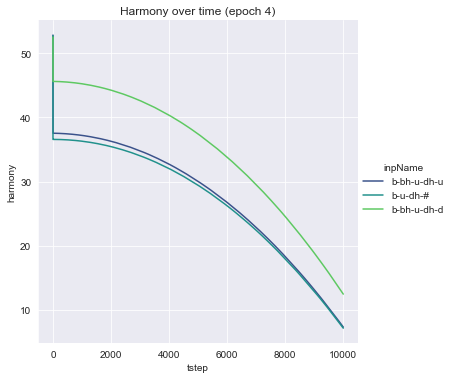

In [22]:
df = p.plot_input_tstep(4,what="harmony")
# Why???

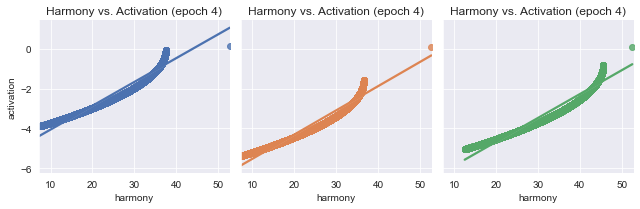

In [23]:
df = p.plot_input_tstep(4,what="regplot_facet")

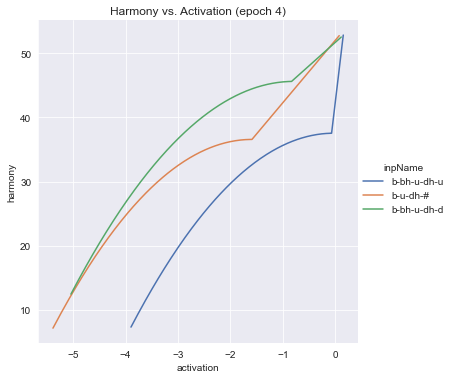

In [24]:
df = p.plot_input_tstep(4,what="regplot")

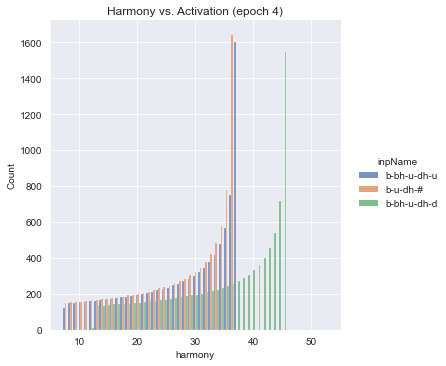

In [25]:
df = p.plot_input_tstep(4,what="harm_dist_inp")

## States update through time

In [26]:
data = p.data
c = data['C_trace']

In [27]:
# Input 0, epoch 4
mat = c[0, 4, i, :, :]
print(mat)
winner = ""
for i in range(mat.shape[1]):
    m = torch.argmax(mat[:,i])
    winner += fillers[m]
print(winner)

tensor([[1.9270e-17, 4.0001e-01, 4.0000e-01, 3.9997e-01],
        [8.0000e-01, 3.9996e-01, 4.0001e-01, 4.0003e-01],
        [4.0001e-01, 1.0000e+00, 4.0002e-01, 1.0000e+00],
        [3.9998e-01, 3.9982e-01, 3.2728e-01, 4.0009e-01],
        [4.0000e-01, 4.0002e-01, 1.0000e+00, 4.0000e-01],
        [3.9997e-01, 3.9983e-01, 4.0001e-01, 4.5880e-01]])
budhu


step: 0 for input b-bh-u-dh-u 
Winner: budh#


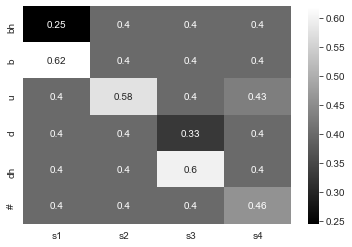

step: 2500 for input b-bh-u-dh-u 
Winner: budhu


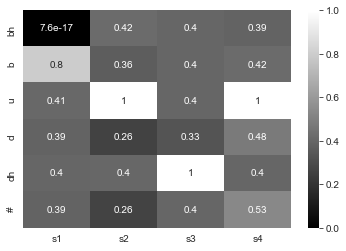

step: 5000 for input b-bh-u-dh-u 
Winner: budhu


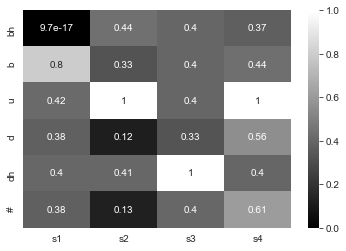

step: 7500 for input b-bh-u-dh-u 
Winner: budhu


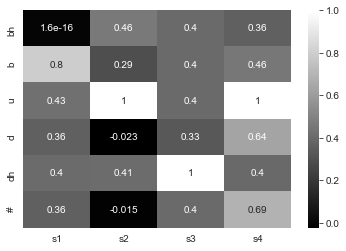

In [28]:
for i in range(0, 10000,2500):
    mat = c[0, 3, i, :, :]
    df = pd.DataFrame(mat.numpy(), index=fillers, columns=roles)
    print(f"step: {i} for input {p.inputNames[0]} ")
    winner = ""
    for i in range(mat.shape[1]):
        m = torch.argmax(mat[:,i])
        winner += fillers[m]
    print(f"Winner: {winner}")
    sns.heatmap(df, annot=True, cmap="gray")
    plt.show()

step: 0 for input b-bh-u-dh-u 
Winner: budh#


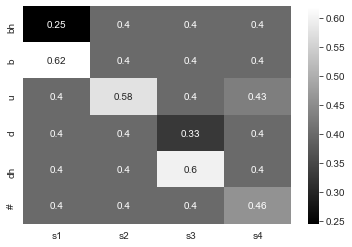

step: 2500 for input b-bh-u-dh-u 
Winner: budhu


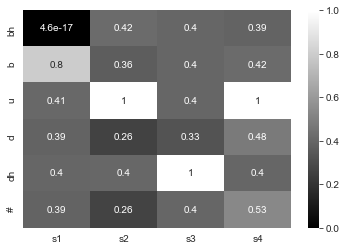

step: 5000 for input b-bh-u-dh-u 
Winner: budhu


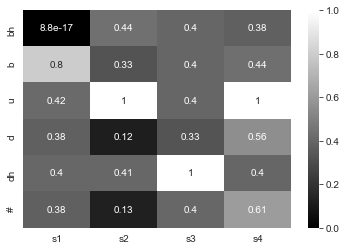

step: 7500 for input b-bh-u-dh-u 
Winner: budhu


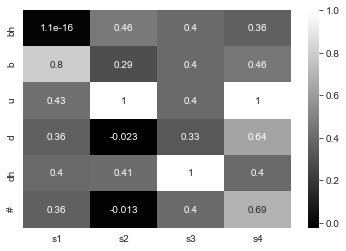

In [29]:
for i in range(0, 10000,2500):
    mat = c[0, 4, i, :, :]
    df = pd.DataFrame(mat.numpy(), index=fillers, columns=roles)
    print(f"step: {i} for input {p.inputNames[0]} ")
    winner = ""
    for i in range(mat.shape[1]):
        m = torch.argmax(mat[:,i])
        winner += fillers[m]
    print(f"Winner: {winner}")
    sns.heatmap(df, annot=True, cmap="gray")
    plt.show()